Cross-Validated Mean Squared Error: 1.8295712763173733
Cross-Validated Standard Deviation: 0.07475159286272226


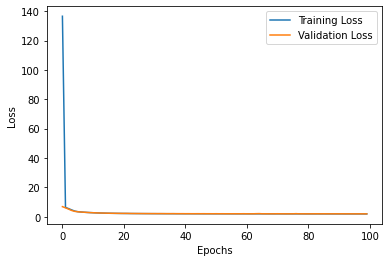

Final Model Mean Squared Error: 1.8503155155035549
MSE: 0.007931763850360657
MAE: 6.089609494960527
R^2: 0.9385704970534792
477/477 [==============================] - 1s 2ms/step - loss: 2.0118 - mean_squared_error: 1.9282
Final training loss: 1.9040896892547607
Final testing loss: [2.0117759704589844, 1.9281952381134033]


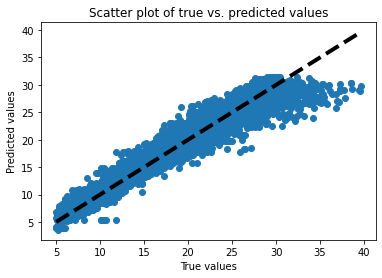

/home/fteshome/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training set:
R2: 0.939999256678413
NSE: 0.9399992566784131
RMSE: 1.3395645093135622
MAE: 0.9498549116126433

Testing set:
R2: 0.9385704970534792
NSE: 0.9385704970534792
RMSE: 1.360263031734508
MAE: 0.9654996322496565


/home/fteshome/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

# Load and preprocess the dataset
data = pd.read_csv('CanopyTempWeatherSC.csv')

# Remove missing values
data = data.dropna() 
data['CanopyTemp'] = data['CanopyTemp'].astype(float)
data_filted = data[(data['CanopyTemp'] >= 5) & (data['CanopyTemp'] <= 40)]

X = data_filted.iloc[:, [6,7]].values

# Perform scaling on the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = data_filted.iloc[:, 4].values 
y = y.reshape(-1, 1)
y = np.ravel(y)

# Define the deep learning model
def create_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(X.shape[1],), activation='relu'))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dense(384, activation='relu'))
    #model.add(Dense(512, activation='relu'))
    #model.add(Dense(1024, activation='relu'))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.1)))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])
    return model

# Perform cross-validation using KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []
for train_index, val_index in kfold.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Create and train the model
    model = create_model()
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=0)
    
    # Evaluate the model on validation set
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    cv_scores.append(mse)

# Calculate the mean and standard deviation of cross-validated scores
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print('Cross-Validated Mean Squared Error:', cv_mean)
print('Cross-Validated Standard Deviation:', cv_std)

# Train the final model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
final_model = create_model()
final_history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=0)

# Plot loss and accuracy for the final model
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluate the final model
y_pred_final = final_model.predict(X_test)
# Create the DataFrame for comparison
T4SCSM1_DeepL = pd.DataFrame({'Measured': y_test.flatten(), 'Estimated': y_pred_final.flatten()})

# Save the DataFrame to a file
T4SCSM1_DeepL.to_csv('SCSM12_DeepL.csv', index=False)


mse_final = mean_squared_error(y_test, y_pred_final)
print('Final Model Mean Squared Error:', mse_final)

mse = np.mean((y_pred_final)- y_test)**2
mae = np.mean(np.abs(y_pred_final - y_test))
r2 = r2_score(y_test, y_pred_final)
print('MSE:', mse)
print('MAE:', mae)
print('R^2:', r2)

testing_loss = model.evaluate(X_test, y_test)

# Print the final training and testing loss
print("Final training loss:", history.history['loss'][-1])
print("Final testing loss:", testing_loss)

plt.scatter(y_test, y_pred_final)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of true vs. predicted values')


# add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# show the plot
plt.show()  


y_train_pred = final_model.predict(X_train)
y_train = y_train.reshape(-1)
y_train_pred= y_train_pred.reshape(-1)
mean_y_train = y_train.mean()
y_train_mean = np.repeat(y_train.mean(), y_train.shape[0])

train_r2 = r2_score(y_train, y_train_pred)
train_nse = 1 - mean_squared_error(y_train, y_train_pred)/mean_squared_error(y_train, y_train_mean)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training set:")
print("R2:", train_r2)
print("NSE:", train_nse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()

DeepLSC_trainmetrics = [
    {'Metric': 'RMSE', 'Value': train_r2},
    {'Metric': 'R2', 'Value': train_nse},
    {'Metric': 'NSE', 'Value': train_rmse},
    {'Metric': 'MAE', 'Value': train_mae}
]

df = pd.DataFrame(DeepLSC_trainmetrics)
df.to_csv('DeepLSC_trainmetrics.csv', index=False)


y_test_pred = final_model.predict(X_test)
y_test = y_test.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
mean_y_test = y_test.mean()
y_test_mean = np.repeat(y_test.mean(), y_test.shape[0])

test_r2 = r2_score(y_test, y_test_pred)
test_nse = 1 - mean_squared_error(y_test, y_test_pred)/mean_squared_error(y_test, y_test_mean)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Testing set:")
print("R2:", test_r2)
print("NSE:", test_nse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

DeepLSC_testmetrics = [
    {'Metric': 'RMSE', 'Value': test_r2},
    {'Metric': 'R2', 'Value': test_nse},
    {'Metric': 'NSE', 'Value': test_rmse},
    {'Metric': 'MAE', 'Value': test_mae}
]

df = pd.DataFrame(DeepLSC_testmetrics)
df.to_csv('DeepLSC_testmetrics.csv', index=False)